# Статистический анализ данных сервиса аренды самокатов GoFast

Целью данного исследования явлется аналаиз данных пользователей сервиса аренды самокатов и их поездок и проверка трех гипотез:
- пользователи с подпиской трятят больше времени на поездки;
- cреднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
- помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from math import factorial
from math import sqrt
from scipy.stats import binom

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

users.info()
rides.info()
subscriptions.info()

display(users.head(), rides.head(), subscriptions.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Col

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод**

В трех датафреймах есть информация о пользователях, их поездках и подписках.

- Пустые значения в датафреймах отсутствуют. 
- В датафрейме `rides` столбец с датой имеет тип данных object. Его необходимо будет привести к типу даты pandas.
- В двух датафреймах (`users` и `rides`) есть одинаковый столбец `user_id`, по которому в дальнейшем можно будет сцеплять таблицы.
- В датафреймах `users`и `subscriptions` есть столбец `subscription_type`, по которому можно будет объединить таблицы.
- В датафрейме `subscriptions` всего две строки, которые содержат данные о двух типах подписки: бесплатной и платной (`free` и `ultra`).
- Больше всего строк в датафрейме, сдержащем информацию о поездках, 18068.

#### Шаг 2. Предобработка данных

In [3]:
#Приведем столбец с датой к типу datetime
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [4]:
#Создадим новый столбец с номером месяца
rides['month'] = rides['date'].dt.month

In [5]:
#Проверяем наличие строк-дублей
display(users.duplicated().sum(), rides.duplicated().sum(), subscriptions.duplicated().sum())

31

0

0

In [6]:
#Удалим строки-дубли в датафрейме users
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

**Вывод**

- Тип столбца `date` был приведен к типу pandas datetime.
- Создан новый столбец с номером месяца.
- Удалены строки-дубли в датафрейме `users`.
- Пустых значений в датафреймах нет (было выяснено на этапе изучения данных).


#### Шаг 3. Исследовательский анализ данных

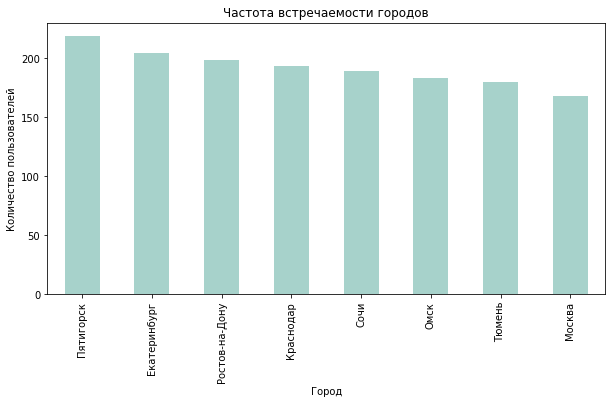

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [7]:
users['city'].value_counts().plot.bar(figsize = (10, 5), color='#A7D2CB')
plt.title('Частота встречаемости городов')
plt.xlabel('Город') 
plt.ylabel('Количество пользователей')
plt.show()
users['city'].value_counts()

**Вывод**

Больше всего пользователей из Пятигорска. Меньше всего из Москвы. В целом, города распределны довольно равномерно. Нет никаких выбросов данных.

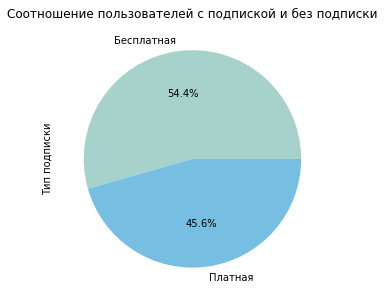

In [8]:
users.groupby('subscription_type')['user_id'].count().\
plot.pie(y='count', labels=['Бесплатная', 'Платная'],figsize=(5, 5), autopct='%1.1f%%', colors=['#A7D2CB', '#77BFE2'])
plt.title('Cоотношение пользователей с подпиской и без подписки')
plt.ylabel('Тип подписки')
plt.show()

**Вывод**

Чуть меньше половины пользователей (45,6%) имеют платную подписку.

In [9]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

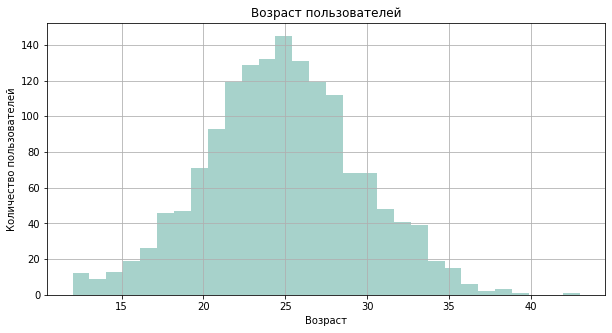

In [10]:
users['age'].hist(bins=30,figsize = (10, 5), color='#A7D2CB')
plt.title('Возраст пользователей')
plt.xlabel('Возраст') 
plt.ylabel('Количество пользователей')
plt.show()

**Вывод**

Средний возраст пользователей сервиса составляет 25 лет. Основная доля пользоватлей находится в возрастной группе от 20 до 28 лет.

In [11]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

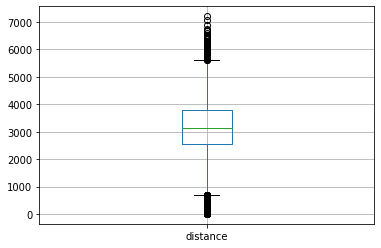

In [12]:
rides.boxplot(column=['distance'])
plt.show()

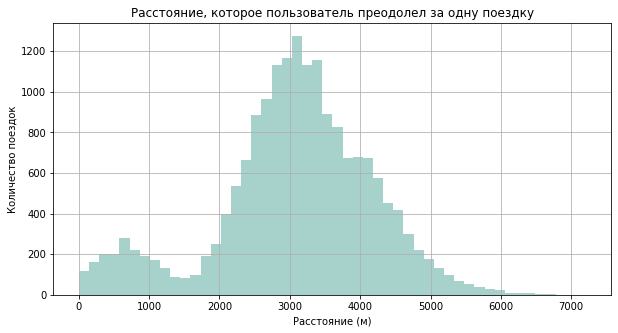

In [13]:
rides['distance'].hist(bins=50,figsize = (10, 5), color='#A7D2CB')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние (м)') 
plt.ylabel('Количество поездок')
plt.show()

**Вывод**

Расстояние, которое пользователи проезжают за одну поездку, в среднем составляет чуть больше 3 км (3071 м).
Основная доля пользователей проехала от 2,5 до 3,8 км за одну поездку.
Есть поездки меньше одного метра. Скорее всго они связаны с тем, что пользователь не смог по какой-то причине прокатиться на самокате (поломка самоката,технический сбой в приложении, не понравилось/не получилось управлять самокатом). Для более дальних поездок-от 6 км самокаты также используются, но доля таких пользователе мала.

In [14]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

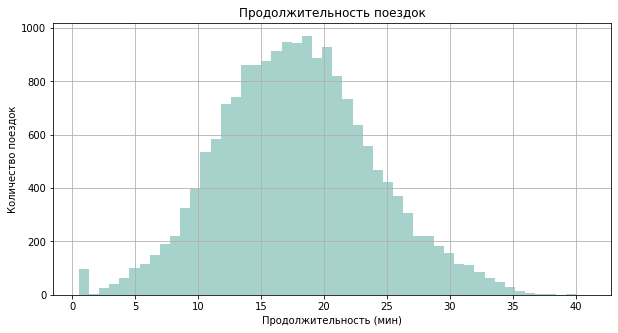

In [15]:
rides['duration'].hist(bins=50,figsize = (10, 5), color='#A7D2CB')
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность (мин)') 
plt.ylabel('Количество поездок')
plt.show()

**Вывод**

Средняя продолжительность поездки составляет 17,7 мин. Оснавная доля поездок длится от 13,6 до 21,7 мин. Есть поездки меньше 3 минут и даже меньше минуты. Скорее всего, по аналогии с поездками на маленькие рассотояния, такая ддительность свазана с техническими проблемами, возникшими у пользователя.

#### Шаг 4. Объединение данных

In [16]:
data_merged = users.merge(rides, on='user_id')
data_merged = data_merged.merge(subscriptions, on='subscription_type')
data_merged.info()
#Датафрейм с данными о пользователях с подпиской
data_merged_subscr = data_merged.loc[data_merged['subscription_type']=='ultra']
#Датафрейм с данными о пользователях без подписки
data_merged_no_subscr = data_merged.loc[data_merged['subscription_type']=='free']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


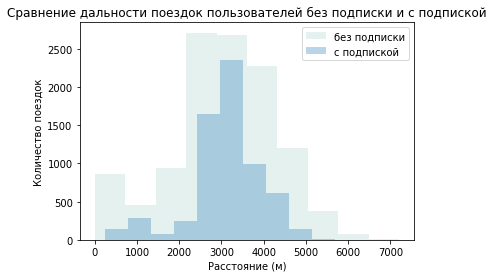

In [17]:
plt.hist(x = data_merged_no_subscr['distance'], alpha = 0.3, label='без подписки', color='#A7D2CB')
plt.hist(x = data_merged_subscr['distance'], alpha = 0.3, label='с подпиской');

plt.title('Сравнение дальности поездок пользователей без подписки и с подпиской')
plt.xlabel('Расстояние (м)') 
plt.ylabel('Количество поездок')
plt.legend()
plt.show()

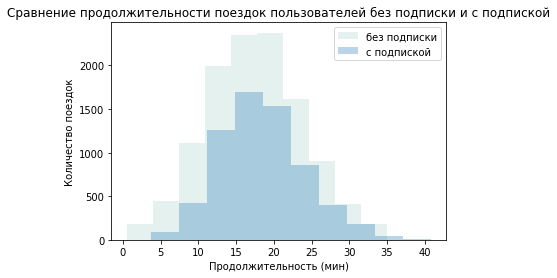

In [18]:
plt.hist(x = data_merged_no_subscr['duration'], alpha = 0.3, label='без подписки', color='#A7D2CB')
plt.hist(x = data_merged_subscr['duration'], alpha = 0.3, label='с подпиской');
plt.title('Сравнение продолжительности поездок пользователей без подписки и с подпиской')
plt.xlabel('Продолжительность (мин)') 
plt.ylabel('Количество поездок')
plt.legend()
plt.show()

In [19]:
display(data_merged_no_subscr[['distance', 'duration']].describe(),\
        data_merged_subscr[['distance', 'duration']].describe())

,distance,duration
count,11568.000000,11568.000000
mean,3045.495282,17.390909
std,1246.173806,6.326803
min,0.855683,0.500000
25%,2366.562689,12.958437
50%,3114.648465,17.326890
75%,3905.697894,21.594071
max,7211.007745,34.948498


,distance,duration
count,6500.000000,6500.000000
mean,3115.445388,18.541985
std,836.895330,5.572048
min,244.210438,3.760353
25%,2785.444017,14.524654
50%,3148.637229,18.178153
75%,3560.574425,21.884129
max,5699.769662,40.823963


**Вывод**

У пользователей без подписки больший разброс данных, чем у пользователей с платной подпиской.

У пользователей без подписки есть очень короткие и очень быстрые поездки - до 1 метра и до 3 минут соответвенно. 
У пользователей с платной подпской дальность поездки начинается от 250 м, а длительность от 3,7 мин. Это может говрить о том, что пользователи с платной подспикой более опытные и у них случается меньше технических причин, чтобы отказаться так быстро от поездки.

Однако, если смотреть на диапазоны, в которые попадает основная масса поездок, то они очень схожи для двух категорий пользователей. Средние и медианы у них также очень близки.


#### Шаг 5. Подсчёт выручки

In [20]:
data_pivoted = data_merged.pivot_table(
    index=['user_id', 'month'],
    values=['distance','duration','minute_price','start_ride_price','subscription_fee','subscription_type'],
    aggfunc={'distance':['count','sum'], 'duration':'sum',\
             'subscription_type':'first','minute_price':'first','start_ride_price':'first',\
             'subscription_fee':'first'}
)
#data_pivoted=data_pivoted.droplevel(1, axis=1)
data_pivoted.columns=['number_of_rides', 'distance', 'duration',\
                      'minute_price','start_ride_price','subscription_fee','subscription_type' ]
data_pivoted['duration'] = np.ceil(data_pivoted['duration'])
data_pivoted['revenue'] = (data_pivoted['start_ride_price']*data_pivoted['number_of_rides'])+\
(data_pivoted['minute_price']*data_pivoted['duration'])+data_pivoted['subscription_fee']
data_pivoted.head(10)

number_of_rides      distance  duration  minute_price  \
user_id month                                                          
1       1                    2   7027.511294      42.0             6   
        4                    1    754.159807       7.0             6   
        8                    2   6723.470560      45.0             6   
        10                   2   5809.911100      32.0             6   
        11                   3   7003.499363      54.0             6   
        12                   2   6751.629942      28.0             6   
2       3                    3  10187.723006      61.0             6   
        4                    2   6164.381824      40.0             6   
        6                    1   3255.338202      14.0             6   
        7                    2   6780.722964      47.0             6   

               start_ride_price  subscription_fee subscription_type  revenue  
user_id month                                                                 
1       1                     0               199             ultra    451.0  
        4                     0               199             ultra    241.0  
        8                     0               199             ultra    469.0  
        10                    0               199             ultra    391.0  
        11                    0               199             ultra    523.0  
        12                    0               199             ultra    367.0  
2       3                     0               199             ultra    565.0  
        4                     0               199             ultra    439.0  
        6                     0               199             ultra    283.0  
        7                     0               199             ultra    481.0

#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки?

Необходимо проверить односторонню гипотезу.

Нулевая гипотеза H0: среднее время поездки пользователей из двух групп равны.

Альтернативная гипотеза H1: среднее время поездки пользователей с подпиской больше, чем без подписки.

In [21]:
with_subscription = data_merged_subscr['duration']
without_subscription = data_merged_no_subscr['duration']

# задаём уровень значимости
alpha = 0.05

# проводим ttest, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(
    with_subscription, 
    without_subscription, 
    alternative='greater')

#print(f'p-value: {"{:.10f}".format(results.pvalue)}')
print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')
    
#Проверим также средние значения
print()
print(f'Средняя продолжительность поездки пользователей с подпиской: {data_merged_subscr["duration"].mean()}')
print(f'Средняя продолжительность поездки пользователей без подписки: {data_merged_no_subscr["duration"].mean()}')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу

Средняя продолжительность поездки пользователей с подпиской: 18.54198516280583
Средняя продолжительность поездки пользователей без подписки: 17.39090929866399


Полученное значение p-value значительно меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания полагать, что пользователи с подпиской тратят больше времени на поездки.

##### Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?




Необходимо проверить односторонню гипотезу.

Нулевая гипотеза H0: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров.

Альтернативная гипотеза H1: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку меньше 3130 метров.

In [22]:
with_subscription = data_merged_subscr['distance']
distance = 3130
alpha = 0.05

results = st.ttest_1samp(
    with_subscription, 
    distance,
    alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 


p-значение: 0.08046311521502146
Не отвергаем нулевую гипотезу


Полученное значение p-value оказалось выше заданного уровня значимости. Следовательно мы не можем отвергнуть нулевую гипотезу о равенстве расстояния, которое проезжают пользователи с подпиской за одну поездку, 3130 метрам. Медианное значение оставляет 3148,6. Таким образом, привлечение большего числа пользователей с платной подпиской не сократит скорость износа самокатов.

##### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Необходимо проверить односторонню гипотезу.

Нулевая гипотеза H0: помесячная выручка от пользователей с подпиской и без подписки равна.

Альтернативная гипотеза H1: помесячная выручка от пользователей с подпиской больше, чем выручка от пользователей без подписки.

In [23]:
with_subscription = data_pivoted.loc[data_pivoted['subscription_type']=='ultra']['revenue'].reset_index(drop=True)
without_subscription = data_pivoted.loc[data_pivoted['subscription_type']=='free']['revenue'].reset_index(drop=True)

results = st.ttest_ind(
    with_subscription, 
    without_subscription,
    alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


Полученное значение p-value значительно меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания полагать, что помесячная выручка от пользователей с подпиской больше, чем выручка от пользователей без подписки.

#### Общий вывод

Были получены данные о пользователях сервиса аренды самокатов, а также об их поездках.
Задача: проанализировать данные и проверить три гипотезы, которые могут помочь бизнесу вырасти.

**На этапе предобработки были внесены следующие изменения в данные:**

- Столбец `date` приведен к типу даты pandas
- Создан новый столбце с номером месяца
- Удалены строки-дубликаты

**На этапе исследовательского анализа данных были получены следующие выводы о пользователях сервиса:**

- Чуть меньше половины пользователей (46%) имеют платную подписку
- Средний возраст пользователей сервиса составляет 25 лет
- Расстояние, которое пользователи проезжают за одну поездку, в среднем составляет чуть больше 3 км (3071 м)
- Средняя продолжительность поездки составляет 17,7 мин

**Чтобы понять стоит ли мотивировать пользователей приобретать платную подписку было проверено 3 гипотезы:**

По результатам проверки гипотез можно сделать следующие выводы:
- Пользователи с подпиской тратят больше врмени на поездки, чем пользователи без подписки.
- Мы не можем утверждать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Данная гипотеза не подтвердилась. Медианное значение оставляет 3148,6. Таким образом, привлечение большего числа пользователей с платной подпиской не сократит скорость износа самокатов.
- Помесячная выручка от пользователей с подпиской больше, чем выручка от пользователей без подписки.

**Рекомендации**

На основании проведенного анализа данных рекомендуем проведение акций с целью увеличения числа пользователей с платной подпсикой, что будет способствовать росту выручки компании.